![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

import matplotlib.pyplot as plt

In [20]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [21]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [22]:
# Cálcular promedio, máximo, mínimo, desviación estándar, mediana, y percentiles para cada temporada
season_metricas = bikes.groupby('season')['total'].agg(['mean', 'max', 'min', 'std', 'median', 
                                                        lambda x: x.quantile(0.25),
                                                        lambda x: x.quantile(0.5),
                                                        lambda x: x.quantile(0.75)]).rename(columns={'<lambda_0>': '25th percentile','<lambda_1>': '50th percentile', 
                                                                                                     '<lambda_2>': '75th percentile'})

# Mostrando las métricas calculadas para "season"
print(season_metricas)

              mean  max  min         std  median  25th percentile  \
season                                                              
1       116.343261  801    1  125.273974    78.0             24.0   
2       215.251372  873    1  192.007843   172.0             49.0   
3       234.417124  977    1  197.151001   195.0             68.0   
4       198.988296  948    1  177.622409   161.0             51.0   

        50th percentile  75th percentile  
season                                    
1                  78.0            164.0  
2                 172.0            321.0  
3                 195.0            347.0  
4                 161.0            294.0  


In [23]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [24]:
# Cálcular promedio, máximo, mínimo, desviación estándar, mediana, y percentiles para cada temporada
hour_metricas = bikes.groupby('hour')['total'].agg(['mean', 'max', 'min', 'std', 'median', 
                                                        lambda x: x.quantile(0.25),
                                                        lambda x: x.quantile(0.5),
                                                        lambda x: x.quantile(0.75)]).rename(columns={'<lambda_0>': '25th percentile','<lambda_1>': '50th percentile', 
                                                                                                     '<lambda_2>': '75th percentile'})

# Mostrando las métricas calculadas para "season"
print(hour_metricas)

            mean  max  min         std  median  25th percentile  \
hour                                                              
0      55.138462  283    2   43.620012    41.0            24.00   
1      33.859031  168    1   34.112105    19.0            11.00   
2      22.899554  119    1   26.110267    11.0             5.00   
3      11.757506   66    1   12.666442     6.0             3.00   
4       6.407240   28    1    4.217633     6.0             3.00   
5      19.767699   57    1   12.784293    19.0             8.00   
6      76.259341  213    1   54.745333    75.0            24.50   
7     213.116484  596    1  159.207044   208.0            63.00   
8     362.769231  839    8  231.723065   392.0           133.50   
9     221.780220  414   14   92.099209   217.0           161.00   
10    175.092308  539   17  101.807629   149.0           106.00   
11    210.674725  647   10  127.444294   183.0           123.00   
12    256.508772  757    3  143.881880   234.5           157.0

## > Evaluación e interpretación de Resultados Punto 1 - Análisis de la variable "season"
La variable "season" corresponde a las temporadas del año, codificada como 1 para invierno (winter(, 2 para primavera (spring), 3 para verano (summer) y 4 para otoño (fall). Observando las medias de alquiler de bicicletas por temporada, podemos inferir lo siguiente:

- Invierno (1): La demanda es la más baja con una media de 116.34 alquileres. Esto es esperable, ya que el clima frío y las condiciones adversas e inseguras suelen desincentivar el uso de bicicletas.

- Primavera (2): Hay un notable incremento en la demanda, con una media de 215.25 alquileres. La mejora del clima en esta estación probablemente contribuye a un mayor interés por actividades al aire libre como el ciclismo.

- Verano (3): La temporada muestra la demanda más alta con una media de 234.42 alquileres. El verano suele ser ideal para el ciclismo debido a las condiciones climáticas más favorables y las vacaciones escolares y vacacions laborales.

- Otoño (4): Se observa una disminución en la demanda comparada con el verano, con una media de 199 alquileres, pero sigue siendo significativamente apreciable. El clima aún es moderado, esto aún permite continuar con el uso frecuente de bicicletas.

Los datos obtenidos muestran una amplia gama en la demanda diaria de alquileres dentro de cada temporada, como indican las diferencias entre los mínimos, máximos, y los valores de los percentiles. Esas fluctuaciones que se flejan en los resultados corresponden a la estacionalidad de la demanda, es decir a las fluctuaciones en la demanda de alquiler de bicicleta en función de la temporada del añno, tipo de día (hábil (lunes, martes, miércoles, jueves, viernes), fin de semana (sábado, domingo), feriados (añno nuevo, semana santa, etc etc.))


### Horario de la Madrugada (0-4)
- **Demanda baja:** La demanda empieza siendo baja y alcanza su punto más bajo alrededor de las 4 horas
- **Variabilidad:** Hay una variabilidad notablemente baja, especialmente a las 4 horas, donde la desviación estándar disminuye, indicando poca variación en la cantidad de alquileres.
- **Percentiles:** La demanda aumenta ligeramente a las 5 a.m., esto debido a las personas que empiezan temprano su jornada laboral o actividades físicas.

### Horario de Entrada al Trabajo/Escuela - Pico AM (5-9)
- **Incremento significativo en la demanda:** Se observa un aumento dramático en la demanda, especialmente entre las 7 y 8 horas, con promedio de alquileres 213 y 362 respectivamente, y el máximo de alquileres alcanzando 596 y 839, respectivamente.
- **Desviación estándar y percentiles:** La variabilidad aumenta con el pico de la mañana, reflejando una mayor dispersión en la cantidad de alquileres.

### Mediodía y Tarde - Entre Valles (10-16)
- **Demanda consistente:** La demanda se mantiene relativamente alta y constante a lo largo del día, con un ligero incremento hacia las 16 horas.
- **Variabilidad:** La desviación estándar se mantiene elevada, indicando variabilidad en la demanda (estacionalidad de la demanda).

### Horario de Salida del Trabajo - Pico PM (17-19)
- **Pico de demanda en la tarde:** El máximo pico ocurre a las 17 y 18 horas, con promedios de alquileres 468 y 430  respectivmente, y con máximos de 970 y 977 alquileres respectivamente, lo que indica un uso intensivo de las bicicletas para el regreso a casa después del trabajo y/o escuela.
- **Alta variabilidad:** La desviación estándar es alta, mostrando una gran dispersión en los datos de alquiler muy seguramnte influencidos por la agregaci'on de datos de todos los meses del añno y tipos dias difrentes (hábil sábado domingo feriados).

### Horario de Noche (20-23)
- **Disminución de la demanda:** A medida que avanza la noche, la demanda disminuye gradualmente reflejando que se disminuyen las actividades socioeconómicas de la población.
- **Variabilidad y percentiles:** La variabilidad disminuye con la demanda, indicando una mayor consistencia en los alquileres nocturnos en comparación con las horas pico.

### Observaciones Generales
- **Patrones de demanda diarios claros:** Hay dos picos principales de demanda (pico AM y pico PM), coincidiendo con el horario de entrada y salida del trabajo, reflejando un uso significativo de las bicicletas para el desplazamiento laboral.
- **Demanda nocturna:** Aunque disminuye respecto a las horas pico, hay una demanda sostenida hasta cerca de medianoche, lo que puede indicar actividades de ocio o personas que trabajan hasta tarde.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

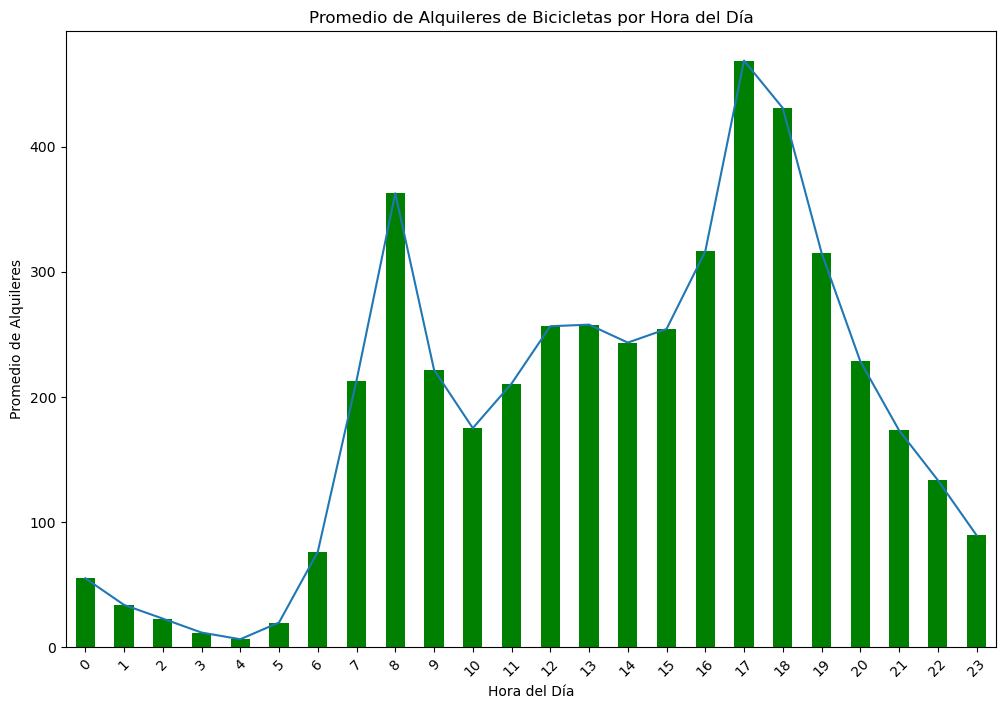

In [25]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

# Calcular promedio de alquiler por hora
hourly_averages = bikes.groupby('hour').total.mean()

# Crear gráfico de barras
hourly_averages.plot(kind='bar', color='green', figsize=(12, 8))

# Crear título y etiquetas
plt.title('Promedio de Alquileres de Bicicletas por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Alquileres')
plt.xticks(rotation=45)

# Mostrar gráfico resultados
plt.show()

## > Evaluación e interpretación de resultados del punto 2 - Análisis de la variable "hour"
La variable "hour" representa la hora del día, dentro del rango 0 a 23 horas. Los patrones de alquiler de bicicletas a lo largo de las horas muestran claramente el comportamiento de los usuarios y sus necesidades de movilidad:

- Franja entre las 0:00 y 5:59 horas. Las horas con menor actividad son desde la medianoche hasta las 5 a.m., siendo las 4 a.m. la hora con la demanda más baja (6.41 alquileres en promedio). Esto refleja el menor movimiento de personas durante las horas de madrugada.

- Franja entre 6:00 y 09:59 horas. A partir de las 6 a.m., la demanda comienza a aumentar, alcanzando picos significativos en horas de la mañana (7 a.m. y 8 a.m.) con 213.12 y 362.77 alquileres en promedio respectivamente, respectivamente. Esto se atribuye al uso de bicicletas para desplazamientos al trabajo o estudio (direccion casa al trabajo/escuela).

- Franja entre 10:00 y 15:59 horas. Este rango de tiempo tambien conocido como entre-picos se aprecia que la demanda por alquiler de bicicletar se mantiene en un volumen medio alto que se incrementa paulatinamente hacia la horas de la tarde.

- Franja entre 16:00 y 19:59. Pico de la Tarde, la demanda se mantiene alta, con otro pico pronunciado en la tarde (5 p.m. y 6 p.m.) con 468.77 y 430.86 alquileres. Esto refleja el patrón de uso para el regreso a casa después del trabajo o la escuela (direccion trabajo/escuela a la casa).

- Franja entre 18:00 y 24:00 horas. La demanda disminuye gradualmente a lo largo de la noche.


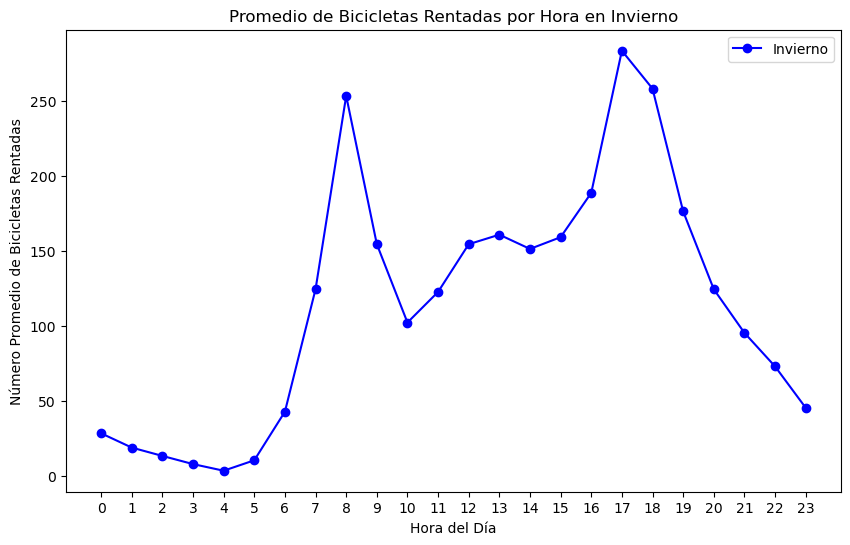

In [26]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

# Filtrar datos para la temporada Invierno
bikes_invierno = bikes[bikes['season'] == 1]

# Calcular promedio  alquileres por hora para la temporada Invierno
average_rentals_invierno = bikes_invierno.groupby('hour')['total'].mean()

# Crear gráfica
plt.figure(figsize=(10, 6))

# Graficar los promedios de alquileres por hora para la temporada Invierno
plt.plot(average_rentals_invierno.index, average_rentals_invierno.values, label='Invierno', marker='o', color='blue')

# Añadir título y etiquetas para los ejes
plt.title('Promedio de Bicicletas Rentadas por Hora en Invierno')
plt.xlabel('Hora del Día')
plt.ylabel('Número Promedio de Bicicletas Rentadas')
plt.xticks(range(0, 24))  # Asegurar eje x muestre cada hora

# Añadir  leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

## 2.2 Promedio de Bicicletas Rentadas por Hora en Invierno:
- **Horaro de Madrugada (0 a 5 a.m.):** La actividad es mínima, lo que es esperable durante las horas frías de invierno.

- **Horario de Entrada al Trabajo/Escuela - Pico AM (6 a 8 a.m.):** Hay un aumento significativo que indica el uso de bicicletas para desplazarse al trabajo o escuela, aunque es menos pronunciado que en verano.

- **Horario Entre Picos - Actividad diurna (9 a.m. a 3 p.m.):** Se nota una actividad más constante a lo largo del día con pequeñas fluctuaciones.

- **Horario de Salida del Trabajo - Pico PM (4 a 5 p.m.):** Se alcanza el pico más alto alrededor de las 5 p.m. ocasonados por los desplazamientos de regreso a los domicilios de los clientes (trabajadores, estudiantes, etc).

- **Horario Nocturno (después de las 6 p.m.):** La actividad disminuye paulatinamente hacia la noche.


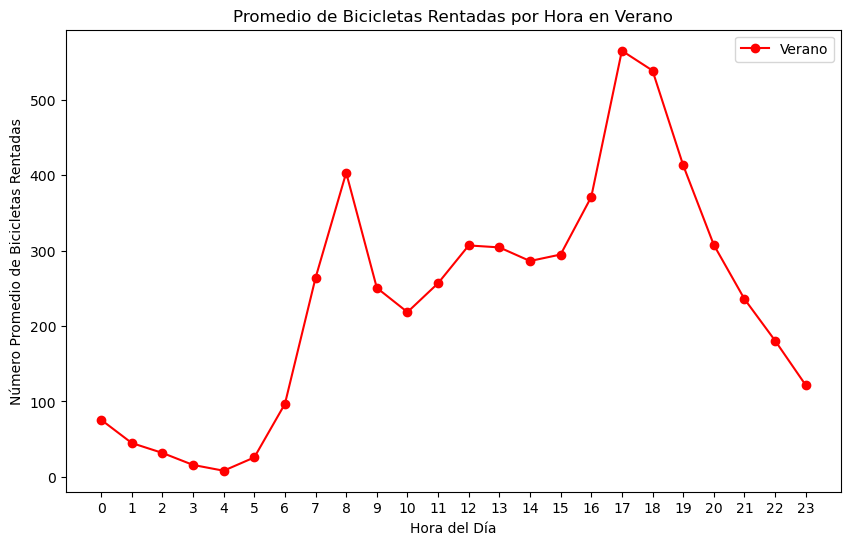

In [27]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 

# Filtrar datos para la temporada Verano
bikes_verano = bikes[bikes['season'] == 3]

# Calcular promedio  alquileres por hora para la temporada Verano
average_rentals_verano = bikes_verano.groupby('hour')['total'].mean()

# Crear gráfica
plt.figure(figsize=(10, 6))

# Graficar los promedios de alquileres por hora para la temporada Verano
plt.plot(average_rentals_verano.index, average_rentals_verano.values, label='Verano', marker='o', color='red')

# Añadir título y etiquetas para los ejes
plt.title('Promedio de Bicicletas Rentadas por Hora en Verano')
plt.xlabel('Hora del Día')
plt.ylabel('Número Promedio de Bicicletas Rentadas')
plt.xticks(range(0, 24))  # Asegurar eje x muestre cada hora

# Añadir  leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

## 2.3 Promedio de Bicicletas Rentadas por Hora en Verano:
- **Horaro de Madrugada (0 a 5 a.m.):** Similar al invierno, hay poca actividad en estas horas, pero se nota un comienzo más temprano del incremento matutino.

- **Horario de Entrada al Trabajo/Escuela - Pico AM (6 a 8 a.m.):** Existe un aumento más marcado y temprano, reflejando una mayor disposición a usar bicicletas en clima cálido.

- **Horario Entre Picos - Actividad diurna (9 a.m. a 3 p.m.):** La actividad se mantiene alta, esto como resultado del aumento de las actividades socioeconomicas relacionadas con el  ocio y actividades turísticas, además de los desplazamientos habituales.

- **Horario de Salida del Trabajo - Pico PM (4 a 5 p.m.):** El pico de la tarde es mucho más pronunciado en verano, lo que indica una mayor tendencia a utilizar las bicicletas para el regreso a casa o para disfrutar del tiempo libre en un clima agradable.

- **Horario Nocturno (después de las 6 p.m.):** Aunque la actividad disminuye, se mantiene más alta en comparación con el invierno, lo cual podría estar relacionado con actividades recreativas que se extienden hasta las horas de la noche.


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [28]:
# Celda 3

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Crear variables dummy para la columna 'season'
season_dummies = pd.get_dummies(bikes['season'], prefix='season', drop_first=True)

# Preparar variables predictoras (X) y la variable de respuesta (y)
X = pd.concat([bikes['hour'], season_dummies], axis=1)
y = bikes['total']

# Iniciar el modelo de regresión lineal
lr = LinearRegression()

# Ajustar el modelo con nuestros datos
lr.fit(X, y)

# Obtener los coeficientes
coeficientes = lr.coef_
intercepto = lr.intercept_

# Imprimir los coeficientes e intercepto
print(f'Intercepto: {intercepto}')
print(f'Coeficientes: {coeficientes}')

# Asignar nombres a coeficientes para facilitar  interpretación
feature_names = ['hour'] + list(season_dummies.columns)
coeficientes_con_nombres = dict(zip(feature_names, coeficientes))

print('-'*80)
print('Coeficientes con nombres de las variables:')
for name, coef in coeficientes_con_nombres.items():
    print(f'{name}: {coef}')

# Si quieres calcular el error cuadrático medio (opcional)
y_pred = lr.predict(X)
mse = mean_squared_error(y, y_pred)
print(f'Error cuadrático medio: {mse}')

Intercepto: -6.430262462304455
Coeficientes: [ 10.54520609 100.31723192 119.46754995  84.08311787]
--------------------------------------------------------------------------------
Coeficientes con nombres de las variables:
hour: 10.545206094069695
season_2: 100.31723191606625
season_3: 119.46754994593346
season_4: 84.08311787296878
Error cuadrático medio: 25480.694694371618


## > Evaluación e interpretación de resultados del punto 3

### Intercepto
- **Intercepto (-6.43):** Este valor representa el punto de partida del modelo; es decir, el número esperado de bicicletas rentadas cuando la hora es 0 y es la temporada base (invierno, o season_1 en este caso). Nota: Dado que un valor negativo para el total de bicicletas rentadas no tiene sentido práctico y se debe interprtar con cautela.

### Coeficientes
- **Hora (10.55):** Por cada hora adicional en el día, el número esperado de bicicletas rentadas aumenta en promedio por 10.55 unidades. Esto refleja un incremento general en el uso de bicicletas a medida que avanza el día, probablemente alcanzando un pico durante las horas de tarde. La naturaleza lineal de la relación entre la hora del día y el total de bicicletas rentadas, asumida por un modelo de regresión lineal simple, no captura la disminución en el número de bicicletas rentadas que típicamente ocurre después de las horas pico de la tarde. En la realidad, la relación entre la hora y el alquiler de bicicletas es más compleja y muestra un patrón no lineal, con incrementos por la mañana y la tarde y una disminución durante la noche y las primeras horas de la mañana.

- **Primavera (season_2, 100.32):** La primavera ve un aumento promedio de 100.32 unidades en el total de bicicletas rentadas en comparación con el invierno. Esto muestra que la primavera es una temporada más popular para el alquiler de bicicletas que el invierno.

- **Verano (season_3, 119.47):** Similar a la primavera, pero aún más pronunciado, el verano muestra un aumento de 119.47 unidades en comparación con el invierno, lo que lo convierte en la temporada con el mayor impacto positivo en el alquiler de bicicletas.

- **Otoño (season_4, 84.08):** Aunque el otoño también muestra un aumento en el número de bicicletas rentadas en comparación con el invierno, el efecto es menor que en la primavera y el verano, con un aumento promedio de 84.08 unidades.

### Error Cuadrático Medio (ECM)
- **ECM (25480.69):** Hay una variabilidad significativa en los datos que el modelo no está capturando completamente. Esto podría ser un indicador de que el modelo es demasiado simple y que podrían necesitarse variables adicionales o un enfoque de modelado diferente para capturar mejor la complejidad del sistema.

### Limitaciones del Modelo de Regresión Lineal
- Los resultados indican una clara variabilidad estacional en el uso de bicicletas, con preferencias aumentadas durante las estaciones más cálidas.
- La hora del día también juega un rol significativo en el número de bicicletas rentadas, con un incremento continuo a lo largo del día.
- El modelo también tiene limitaciones en términos de precisión predictiva, como se refleja en el ECM. Esto podría deberse a la omisión de otras variables relevantes que podrían influir en el alquiler de bicicletas, como el clima (temperatura, precipitación), días de la semana vs. fin de semana, o eventos especiales.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [29]:
# Celda 4

#-----------------------------------------------------------------------------------------------


# Codificar variables categóricas
bikes['season'] = pd.factorize(bikes.season)[0]

# Preparar las variables predictoras y la variable objetivo
X = bikes[['season', 'hour']]
y = bikes['total']
y = (bikes.total > 100).astype(int)


# Construir un árbol de decisión manualmente

# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 10
max_features = None
min_gain=0.001

#-----------------------------------------------------------------------------------------------

# GINI INDEX - GINI IMPURITY 

# Definir la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definir la función gini_imputiry para calular la ganancia de una variable predictora j 
# dado el punto de corte k

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

#-----------------------------------------------------------------------------------------------

# Para todas las variables se calculan posibles puntos de corte y selecciona aquella de menor impureza o ganancia

# Definir función best_split para calcular cuál es mejor variable y punto de cortepara hacer bifurcación del árbol

def best_split(X, y, num_pct):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

#-----------------------------------------------------------------------------------------------

# Obtener la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, num_pct)
j, split, gain

# Añadir aquí la obtención del nombre de la variable usando 'j'
variable_name = X.columns[j]

print(f'Mejor variable para dividir: {variable_name}, Punto de corte: {split}, Ganancia: {gain}')

#-----------------------------------------------------------------------------------------------

# Dividir las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

print('-' * 80)

print(f'Total observaciones: {y.shape[0]}')
print(f'Observaciones <= punto de corte: {y_l.shape[0]}')
print(f'Observaciones > punto de corte: {y_r.shape[0]}')

print('-' * 80)

print(f'Promedio total: {y.mean()}')
print(f'Promedio observaciones <= punto de corte: {y_l.mean()}')
print(f'Promedio observaciones > punto de corte: {y_r.mean()}')


Mejor variable para dividir: hour, Punto de corte: 6.0, Ganancia: 0.20767253145027476
--------------------------------------------------------------------------------
Total observaciones: 10886
Observaciones <= punto de corte: 2684
Observaciones > punto de corte: 8202
--------------------------------------------------------------------------------
Promedio total: 0.6024251331986037
Promedio observaciones <= punto de corte: 0.039120715350223545
Promedio observaciones > punto de corte: 0.7867593269934162


In [30]:
### Crecimiento recursivo del árbol 

# Definir la función tree_grow para hacer un crecimiento recursivo del árbol

def tree_grow(X, y, level=0, min_gain=0.001, max_depth = 6, num_pct = 10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)


In [31]:
### Realizar predicciones usando el árbol creado

# Definir la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejecutar función tree_predict
tree_predict(X, tree)

array([0., 0., 0., ..., 1., 1., 0.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

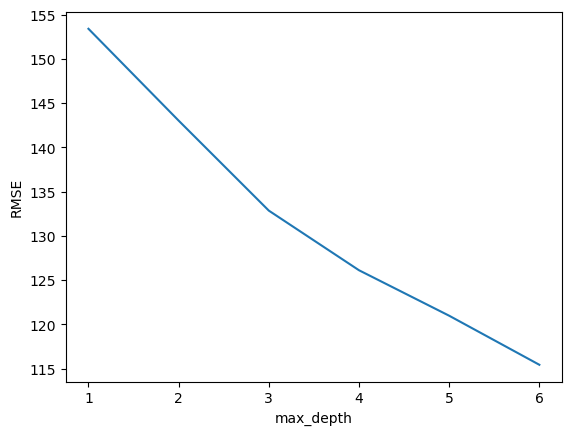

Mejor RMSE: 115.42752834617531 con max_depth: 6
  feature  importance
1    hour    0.877656
0  season    0.122344


In [32]:
# Celda 5

### Construir un árbol de decisiones usando *Sklearn*

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Preparar las variables predictoras y la variable objetivo
X = bikes[['season', 'hour']]
y = bikes['total']


# Importar librerias de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dividir datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Establecer criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 7)

# Crear lista para guardar los valores del RMSE para cada valor de máxima profundidad
rmse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

# Gráficar max_depth versus RMSE
plt.plot(max_depth_range, rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

# Imprimir Mejor RMSE y su correspondiente max_depth
best_score = sorted(zip(rmse_scores, max_depth_range))[0]
print(f"Mejor RMSE: {best_score[0]} con max_depth: {best_score[1]}")

# Imprimir Importancia de las variables
clf = DecisionTreeRegressor(max_depth=best_score[1], random_state=1)
clf.fit(X_train, y_train)
features_importance = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).sort_values(by='importance', ascending=False)
print(features_importance)


## > Evaluación  e interpretación de resultados del punto 5

### Árbol de decisión usando DecisionTreeRegressor de sklearn.
El modelo con nivel de profundidad máxima de 6 resultó ser el más óptimo en términos de minimizar el RMSE (Root Mean Squared Error) en el conjunto de validación. El RMSE indica que en promedio las predicciones del número total de bicicletas rentadas por el modelo se desvían en 115.43 unidades del valor real en el conjunto de validación.

Además, la evaluación de la importancia de las variables indica que la "hora" es considerablemente más influyente en las predicciones del modelo que la "season" (temporada), con aproximadamente el 87.77% de la importancia total atribuida a la "hora", mientras que la "temporada" solo representa el 12.23%.

### Comparación entre Punto 3 y Punto 5.
A diferencia del modelo de regresión lineal (punto 3) que asume una relación lineal entre las variables predictoras y la respuesta, el modelo de árbol de decisión (punto 5) puede capturar relaciones no lineales y de interacción entre las variables sin necesidad de especificar o transformar estas relaciones explícitamente.

Al comparar el RMSE del Punto 5 (RMSE_Pt5 = 115.43) obtenido con el modelo de árbol de decisión, con el RMSE del Punto 3 (RMSE_Pt3 = 159.62, calculado como la raíz cuadrada del MSE = 25480) del modelo de regresión lineal, observamos que el modelo de árbol de decisión tiene un rendimiento superior en términos de precisión de las predicciones. Un RMSE más bajo indica que las predicciones del modelo de árbol de decisión están, en promedio, más cerca de los valores reales, lo que sugiere una mayor precisión en las predicciones comparado con el modelo de regresión lineal.

Los resultados favorables al modelo de árbol de decisión podría atribuirse a varias razones: 
- i) Los árboles de decisión son capaces de capturar relaciones no lineales entre las variables predictoras y la variable objetivo sin necesidad de transformaciones explícitas de las variables, 
- ii) Interacciones entre Variables, la hora y la temporada pueden interactuar de manera compleja para influir en el total de bicicletas rentadas, y un árbol de decisión puede capturar estas interacciones de manera más intuitiva.
- iii) Simplicidad y Flexibilidad con la elección de max_depth=6 para el modelo de árbol de decisión sugiere un modelo relativamente simple que aún es capaz de capturar la estructura subyacente en los datos.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [33]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [34]:
# Definir variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [35]:
# Dividir la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [36]:
# Celda 6

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

#-----------------------------------------------------------------------------------------------
## Árbol de Decisión: Ajuste y Calibración


# Inicializar el clasificador de árbol de decisión
tree_clf = DecisionTreeClassifier(random_state=42)

# Calibrar el parámetro max_depth usando GridSearchCV
param_grid_tree = {'max_depth': np.arange(3, 15)}
grid_tree = GridSearchCV(tree_clf, param_grid_tree, cv=5, scoring='accuracy')
grid_tree.fit(X_train, y_train)

# Mejor modelo y parámetros
best_tree_clf = grid_tree.best_estimator_

# Predicciones y evaluación
y_pred_tree = best_tree_clf.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

print(f"Árbol de Decisión - Mejor Max Depth: {grid_tree.best_params_['max_depth']}, Accuracy: {accuracy_tree:.4f}, F1-Score: {f1_tree:.4f}")

#-----------------------------------------------------------------------------------------------
## Regresión Logística: Ajuste y Evaluación

# Ajustar un modelo de regresión logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_log = log_reg.predict(X_test)
accuracy_log = accuracy_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)

print(f"Regresión Logística - Accuracy: {accuracy_log:.4f}, F1-Score: {f1_log:.4f}")

#-----------------------------------------------------------------------------------------------



Árbol de Decisión - Mejor Max Depth: 3, Accuracy: 0.6413, F1-Score: 0.6073
Regresión Logística - Accuracy: 0.6240, F1-Score: 0.6105


## > Evaluación  e interpretación de resultados del punto 6 -  Árbol de decisiòn vs Regresión logística

#### Árbol de Decisión
- **Profundidad Máx (Max Depth):** 3. Esta es la profundidad óptima encontrada para el árbol, indicando que un modelo relativamente simple fue el más efectivo para este conjunto de datos específico.
- **Accuracy: 0.6413.** Aproximadamente el 64.13% de las predicciones del modelo fueron correctas.
- **F1-Score: 0.6073.** El F1-Score sugiere un equilibrio razonable entre precisión y sensibilidad para el árbol de decisión.

#### Regresión logística
- **Accuracy: 0.6240.** El modelo de regresión logística tuvo una precisión del 62.40% de predicciones correctas.
.
- **F1-Score: 0.6105.** La regresión logística logró un F1-Score de 61.05%, sugiriendo una eficacia similar en términos de equilibrio entre precisión y sensibilidad con el modelo de árbol de decisión.

**Los dos modelos mostraron un desempeño similar en términos de F1-Score, lo que indica que ambos son comparables en cuanto a su equilibrio entre precisión y sensibilidad. Sin embargo, el árbol de decisión tuvo un ligero margen de mejora en términos de accuracy.**

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un ensamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [37]:
# Celda 7

#-----------------------------------------------------------------------------------------------
## Combinación de clasificadores - Votación MAYORITARIA

#  Separar variables predictoras (X) y variable de interés (y) en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Crear Modelo Árbol de decisión con max_depth específico
tree_max_depth = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
                                   n_estimators=100, random_state=42)

# Crear Modelo Árbol  de decisión con min_samples_leaf específico
tree_min_samples_leaf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=20, random_state=42),
                                          n_estimators=100, random_state=42)

# Crear Modelo Regresiones logísticas
log_reg = BaggingClassifier(base_estimator=LogisticRegression(random_state=42, max_iter=1000),
                            n_estimators=100, random_state=42)

# Entrenar los Modelos
tree_max_depth.fit(X_train, y_train)
tree_min_samples_leaf.fit(X_train, y_train)
log_reg.fit(X_train, y_train)

#-----------------------------------------------------------------------------------------------

# Obtener predicciones para cada grupo de modelos
y_pred_max_depth = tree_max_depth.predict(X_test)
y_pred_min_samples_leaf = tree_min_samples_leaf.predict(X_test)
y_pred_log_reg = log_reg.predict(X_test)

# Combinar las predicciones
y_pred_combined = np.vstack((y_pred_max_depth, y_pred_min_samples_leaf, y_pred_log_reg))

# Realizar votación mayoritaria
y_pred_final = (np.sum(y_pred_combined, axis=0) >= (3 / 2)).astype(int)

#-----------------------------------------------------------------------------------------------


# Calcular métricas de desempeño para el ensamble
accuracy = accuracy_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)

print(f"Accuracy del Ensamble Votación Mayoritaria: {accuracy}")
print(f"F1-Score del Ensamble Votación Mayoritaria: {f1}")



Accuracy del Ensamble Votación Mayoritaria: 0.6515151515151515
F1-Score del Ensamble Votación Mayoritaria: 0.6508097165991903


## > Evaluación  e interpretación de resultados del punto 7
El ensamblado de modelos mediante votación mayoritaria ha mostrado una mejora tanto en Accuracy como en F1-Score en comparación con los modelos individuales de árbol de decisión y regresión logística evaluados anteriormente.

Mejora en Accuracy: El ensamble ha logrado un incremento en Accuracy, pasando de 0.6413 con el mejor árbol de decisión a 0.6515. Esto indica que el ensamble es más preciso en la clasificación general de las observaciones.

Mejora significativa en F1-Score: El F1-Score del ensamble es notablemente superior a los de los modelos individuales, pasando de 0.6105 en la regresión logística a 0.6508. Esto sugiere que el ensamble no solo mantiene un buen equilibrio entre precisión y recall, sino que lo mejora significativamente.

La mejora en el desempeño podría atribuirse a la capacidad de los ensambles para combinar las fortalezas de múltiples modelos y mitigar sus debilidades individuales. En este caso, la combinación de diferentes tipos de árboles de decisión y regresiones logísticas ha permitido capturar una variedad más amplia de patrones en los datos, lo que ha resultado en un modelo más robusto y generalizable.

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [38]:
# Celda 8

#-----------------------------------------------------------------------------------------------
## Combinación de clasificadores - Votación PONDERADA

from sklearn.metrics import accuracy_score, f1_score


# Calcular la precisión de cada modelo en el conjunto de entrenamiento con su "peso"
weights = np.array([
    accuracy_score(y_train, tree_max_depth.predict(X_train)),
    accuracy_score(y_train, tree_min_samples_leaf.predict(X_train)),
    accuracy_score(y_train, log_reg.predict(X_train))
])

# Cálcular los pesos alpha basados en la precisión
alpha = weights / weights.sum()

# Combinar las predicciones multiplicándolas por los pesos alpha correspondientes
y_pred_combined_corrected = np.vstack((y_pred_max_depth, y_pred_min_samples_leaf, y_pred_log_reg)).T

# Ponderar las predicciones con los pesos alpha y decisión basada en el umbral 0.5
weighted_sum = np.dot(y_pred_combined_corrected, alpha)
y_pred_weighted = (weighted_sum >= 0.5).astype(int)

# Calcular métricas de desempeño para el ensamble ponderado
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)

print(f"Accuracy del Ensamble Votación Ponderada: {accuracy_weighted}")
print(f"F1-Score del Ensamble Votación Ponderada: {f1_weighted}")


Accuracy del Ensamble Votación Ponderada: 0.6515151515151515
F1-Score del Ensamble Votación Ponderada: 0.6508097165991903


## > Evaluación  e interpretación de resultados del punto 8

Los resultados del ensamble votación ponderado, con un Accuracy de aproximadamente 0.652 y un F1-Score de aproximadamente 0.651, sugiere que para este conjunto de datos y configuración específica de modelos ofrece mejoras  en el rendimiento en comparación con los modelos individuales presentados en el punto 6.

Los resultados indican equilibrio entre Precisión y Sensibilidad toda vez que F1-Score sea casi idéntico al Accuracy sugiere que el modelo ensamblado logra un buen equilibrio entre precisión (la proporción de identificaciones positivas que fueron correctas) y sensibilidad.

Un Accuracy del 65.2% indica que en general el modelo puede predecir correctamente la popularidad de las noticias en aproximadamente casi dos tercios de los casos.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

## Celda 9

La comparación directa entre los resultados del ensamble mediante votacion mayoritaria (Punto 7) y votación ponderada (Punto 8) revela que ambos métodos de ensamble producen exactamente los mismos resultados en términos de Accuracy y F1-Score, ambos con un valor aproximado de 0.6515 para Accuracy y 0.6508 para F1-Score. Este resultado es interesante y sugiere varias consideracioness de análisis:

Ambos enfoques de ensamble Votacion Mayoritaria y Votacion Ponderada mejoran el rendimiento en comparación con los modelos individuales analizados previamente, destacando la eficacia de los métodos de ensamble para combinar múltiples modelos y mejorar la precisión y el balance entre precisión y recuperación (como se refleja en el F1-Score). 

La igualdad de resultados indica que, para este conjunto específico de datos y configuración de modelos, la ponderación basada en el rendimiento de los modelos individuales no proporciona una ventaja discernible entre si. 

La equivalencia de resultados también sugiere que puede haber margen para la exploración y optimización adicional, tanto en la selección y ajuste de los modelos individuales como en las estrategias de ensamble de los mismos.